In [0]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhwang1","key":"6f80ce7088b59bada7f5c3746ca60dbe"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d lantian773030/pokemonclassification

 99% 411M/417M [00:03<00:00, 138MB/s]
100% 417M/417M [00:03<00:00, 143MB/s]


In [0]:
import os
from glob import glob

W = './weights/'


if not(os.path.exists(W)):
  os.makedirs(os.path.join(W,"AE"))
  print('[INFO] Add folder AE')
#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('pokemonclassification.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

[INFO] Add folder AE and VAE


In [0]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

import cv2
from imutils import paths

Using TensorFlow backend.


In [0]:
INPUT_DIM = (96,96,3)
ZDIM = 30
BATCH_SIZE = 20

In [0]:
images = []
labels = []
basePath = './data/PokemonData'
print('[INFO] load images dataset')
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(basePath, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

[INFO] load images dataset
Found 6820 images belonging to 150 classes.


In [0]:
NUM_IMAGES = len(sorted(list(paths.list_images(os.getcwd()))))
NUM_IMAGES

6820

In [0]:
def build_encoder(inputDim,outputDim,convFilter,convKernelsize,convStride):
  # reset backend to zero
  global K
  K.clear_session()

  # number of conv layer
  n_conv = len(convFilter)

  encoder_input = Input(shape = inputDim, name='encoder_input')
  x = encoder_input
  #print(x)
  for i in range(n_conv):
    x = Conv2D(filters=convFilter[i],kernel_size=convKernelsize[i],strides=convStride[i],padding='same',name='encoder_conv_'+str(i+1))(x)
    x = LeakyReLU()(x)
  
  print(K.int_shape(x)) 
  shape_before_flattening = K.int_shape(x)[1:]

  x = Flatten()(x)

  #Def model output
  encoder_output = Dense(outputDim,name='encoder_output')(x)

  return encoder_input,encoder_output,shape_before_flattening,Model(encoder_input,encoder_output)



In [0]:
encoder_input,encoder_output,shape_before_flattening,enc = build_encoder(INPUT_DIM,ZDIM,convFilter=[12,24,36],convKernelsize=[3,3,3],convStride=[2,2,2])

(None, 12, 12, 36)


In [0]:
enc.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 96, 96, 3)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 48, 48, 12)        336       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 12)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 24, 24, 24)        2616      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 24)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 12, 12, 36)        7812      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12, 12, 36)        0   

In [0]:
def decoder(inputDim,shape_before_flattening,convFilter,convKernelSize,convStride):
  # the number of conv layer
  n_conv = len(convFilter)

  # def model input
  decoder_input = Input(shape=(inputDim,),name='decoder_input')

  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_conv):
    x = Conv2DTranspose(convFilter[i],convKernelSize[i],strides=convStride[i],padding="same",name="decoder_conv_"+str(i+1))(x)
    
    if i < n_conv - 1:
      x = LeakyReLU()(x)
    else:
      x = Activation('sigmoid')(x)
    
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [0]:
(decoder_input, decoder_output, decoder_model) = decoder(ZDIM,shape_before_flattening,[12,24,36,3],[2,2,2,2],[2,2,2,1])
decoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5184)              160704    
_________________________________________________________________
reshape_1 (Reshape)          (None, 12, 12, 36)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 24, 24, 12)        1740      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 12)        0         
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 48, 48, 24)        1176      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 48, 48, 24)        0   

In [0]:
ae_model_input = encoder_input

ae_model_output = decoder_model(encoder_output)

ae_model = Model(ae_model_input,ae_model_output)

ae_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 96, 96, 3)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 48, 48, 12)        336       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 12)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 24, 24, 24)        2616      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 24)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 12, 12, 36)        7812      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12, 12, 36)        0   

In [0]:
lr = 0.0005
n_epoches = 10

opt = Adam(lr)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

ae_model.compile(optimizer=opt,loss=r_loss)



In [0]:
ae_model.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = 20, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                )

Epoch 1/20
341/341 [==============================] - 97s 285ms/step - loss: 0.0743
Epoch 2/20
341/341 [==============================] - 97s 283ms/step - loss: 0.0511
Epoch 3/20
341/341 [==============================] - 96s 283ms/step - loss: 0.0456
Epoch 4/20
341/341 [==============================] - 96s 280ms/step - loss: 0.0436
Epoch 5/20
341/341 [==============================] - 99s 291ms/step - loss: 0.0393
Epoch 6/20
341/341 [==============================] - 96s 283ms/step - loss: 0.0380
Epoch 7/20
341/341 [==============================] - 96s 283ms/step - loss: 0.0373
Epoch 8/20
341/341 [==============================] - 97s 283ms/step - loss: 0.0369
Epoch 9/20
341/341 [==============================] - 97s 284ms/step - loss: 0.0366
Epoch 10/20
341/341 [==============================] - 97s 286ms/step - loss: 0.0364
Epoch 11/20
341/341 [==============================] - 99s 290ms/step - loss: 0.0363
Epoch 12/20
341/341 [==============================] - 100s 294ms/step - l

In [0]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = ae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.3, wspace=0.3)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

In [0]:
example_batch = next(data_flow)
print(len(data_flow))
example_batch = example_batch[0]
example_images = example_batch[:10]
example_images.shape

341


(10, 96, 96, 3)

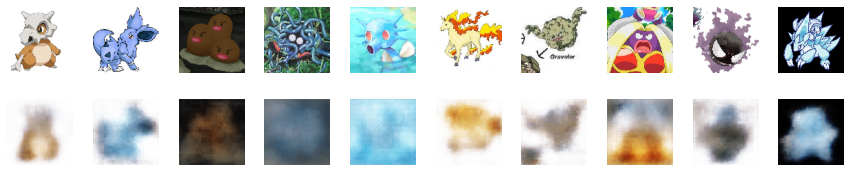

In [0]:
import matplotlib.pyplot as plt
plot_compare(example_images)